# Logistic regression: Understanding hospital one-hot coefficients

> *Motivation*: We predict thrombolysis use, for any patient, at different hospital by changing the one-hot hospital encoding (while keeping all other patient features unchanged). When we passed a 10K set of patients through all hospitals (by changing the one-hot encoding), we expected that the hospital rank order for the predicted thrombolysis use in that 10K cohort patients would be the same as the rank order of model coefficients for each of the hospital one-hot features. But we did not see exactly the same rank order. This notebook explores (and uncovers) the reason for the different rank orders.

> *Key finding*: We discovered that when you standardise the dataset (the process of converting each feature independently to have a mean of 0 and standard deviation of 1), where one-hot features used to have a value of 0 and 1, they each now take a different pair of values. The resulting pair of values depends on how many instances have the value "1" for each hospital (effectively, the hospitals admission rate in the training set). The fewer patients the greater the standardised value for being one-hot. Therefore, with one-hot encoding the contribution of the ‘one hot’ feature depends on both the co-efficient and the standardised value for being one-hot. We cannot therefore take the logistic regression co-efficients in isoltaion and assume that they provide us with the relative importance.

In this notebook we train a combined logistic regression model, and represent the hospital by one-hot encoding. The use of thrombolysis in an independent 10K cohort may then be predicted at each hospital by changing the one-hot encoding to mimic all those 10K patients attending each hospital. 
We then show how the coefficient for the hospital one hot features are not in the same rank as the thrombolysis rate, and show how this is related to the product of the coefficient with the standardised value.

Actions from this notebook:
1) check same hospitals in the train and test set if do a one hot
2) take set of the hospital names and order alphabetically, then go through the hospitals in that order when send all 10k patients to the same hosptial.

Learnt:
With one-hot encoding the contribution of the ‘one hot’ feature depends on both the co-efficient and the standardised value for being one-hot (which varies depending on how many are one-hot for each hopsital - the fewer patients the greater the standardised value for being one-hot). We cannot therefore take the logistic regression co-efficients in isoltaion and assume that they provide us with the relative importance.

"Standardization is useful when your data has varying scales and the algorithm you are using does make assumptions about your data having a Gaussian distribution, such as linear regression, logistic regression, and linear discriminant analysis."
(https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Standardization%20is%20useful%20when%20your,regression%2C%20and%20linear%20discriminant%20analysis.)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np

from pylab import *
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import math #used in the sigmoid function

## Function to standardise data

This converts all features to have a mean of 0 and a standard deviation of 1.

In [2]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Load data

In [3]:
data_loc = '../data/sam_1/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

In [4]:
train.shape

(78792, 89)

## Initialise global objects

In [5]:
hospitals = set(train['StrokeTeam'])
hospital_loop_order = list(set(train['StrokeTeam']))

n_hospitals = len(hospital_loop_order)
n_patients = test.shape[0]

## Model: Logistic regression model. Combined model for all hospitals

Logistic regression model trained using one-hot encoded hospitals

### Train model

Suggestion: Trusting that each Train and Test set has the same hospitals, and so they will create identical ordered hosptial one hots. 
Worth putting in a check that each dataset contains the same set of hosptials, like in the cell below.

In [6]:
list(train) == list(test)

True

In [7]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
list(X_train) == list(X_test)
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Standardise X data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Store number of features
n_features = X_test_std.shape[1]

# Define model
model = LogisticRegression(solver='lbfgs', random_state=42)

# Fit model
model.fit(X_train_std, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test_std)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.8262


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [8]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []
counter = 0

for hospital in hospitals: 
    counter += 1
    print(f'\r{counter}', end='') 

# if print out "hosptials", as this is a set (calculated from 
# set(train['StrokeTeam'])), the loop is not in alphabetical order, it's in 
# another order (not seem to be the order fo first appearance in either)

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Standardised
    X_train_std, X_test_std = standardise_data(X_train, X_test_adjusted)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())

lr_single = thrombolysis_rate

132

### Plot thrombolysis rate of 10K cohort at each hospital

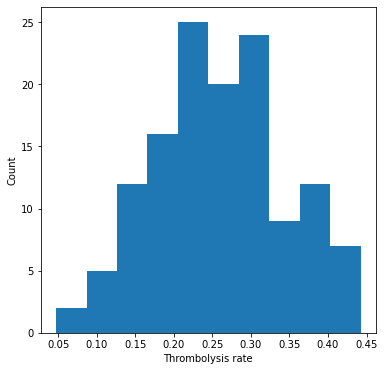

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [10]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.259
StDev: 0.085


## How to determine the hospitals keeness to thrombolyse from the model.

### Plot the hospitals 10k patient thrombolysis rate vs the hospital feature co-efficient.

By design of the combined logistic regression model, each clinical feature has the same coefficient regardless of which hospital the patient attended. Therefore each patient will have the same resulting value from their clinical features, and the only thing that is going to differ in the decision in treatment between hosptials is from the contribution of the hosptial coefficient.

So all patients will have a score, then each hosptial will add (or subtract) a fixed amount from the patients score.

We expected to see that hospitals can be ordered by keeness to thrombolyse based on their hosptial's one hot feature coefficient.

Note: The rank calculations are in reverse order so that the points on the graph showing the ranked postiions are more relatable to the position of the points on the graph showing the raw values. Hhigh thrombolysis rate = high thrombolysis rate ranking position. High weight value = high weight ranking position.

<AxesSubplot:xlabel='Rank of 10K cohort thrombolysis rate', ylabel='Rank of weight'>

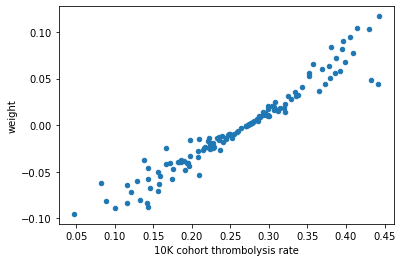

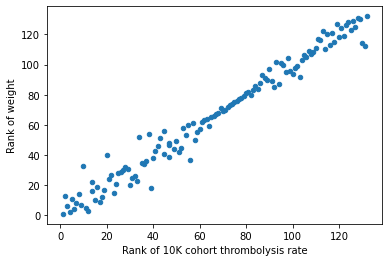

In [11]:
# get feature names
features = list(X_train)
# drop "team_" from the one-hot hospital feature names
feature_names = [i[5:] for i in features]

# get feature weights
feature_weights = model.coef_[0]
weights = pd.DataFrame(index=feature_names)
weights['weight'] = feature_weights

# Put thrombolysis rate in dataframe
thrombo_rate = pd.DataFrame(index=hospital_loop_order)
thrombo_rate['10K cohort thrombolysis rate'] = thrombolysis_rate

# join the dataframes on index value, and limit to just those that have values
# in both dataframes (we will get just the hosptials)
df_weights_thrombrate = weights.join(thrombo_rate, how='inner')

# plot scatter of thrombolysis rate vs weight
df_weights_thrombrate.plot.scatter(x='10K cohort thrombolysis rate', 
                                   y='weight')

# calculate ranks
# note that ranks are in reverse order so that the points on the graph are
# more relatable to the position of the raw values
# (high thrombolysis rate = high thrombolysis rate ranking position)
# (high weight value = high weight ranking position)
df_weights_thrombrate['Rank of weight'] = (
                df_weights_thrombrate['weight'].rank(ascending=True).values)

df_weights_thrombrate['Rank of 10K cohort thrombolysis rate'] = (
                df_weights_thrombrate['10K cohort thrombolysis rate'].rank(
                                                        ascending=True).values)

# plot scatter of ranks (thrombolysis rate vs weight)
df_weights_thrombrate.plot.scatter(x='Rank of 10K cohort thrombolysis rate', 
                                   y='Rank of weight')

The hospital feature coefficient value did not align with the hospitals thrombolysis rate. 
And neither did the ranked position of each variable.

Why could this be?

### Standardised values for one-hot features

It is due to the contribution from each hospital is a combination of the hosptial feature coefficient, and the feature value when standardising the data. 

Standardising the data scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

This means that each hospital will have a different standardised value based on the number of admissions for the hospital in the training dataset (the number of times "1" is present, as this will effect the mean and standard deviation of that feature). A hospital with fewer patients will have fewer value "1" and more value "0", hence the standardised values will be larger so as to obtain the mean 0 stddev 1. 

For example if 200/78792 patients go to hospital A, then the standardise values are 0: -0.05 and 1: 19.8.\
For example if 50000/78792 patients go to hospital B then the standardise values are 0: -1.3 and 1: 0.7

### Plot the pairing of standardised values, with each point coloured by the hospital admission values

<AxesSubplot:xlabel='standardised0', ylabel='standardised1'>

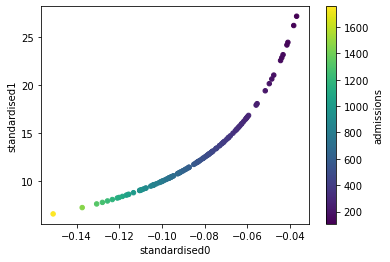

In [12]:
# start position in the features list of the one hot hospital features
st_pos = n_features - n_hospitals

# calculate admission rates (per hospital)
np_unique = np.unique(train["StrokeTeam"], return_counts=True)
df_hospital_admissions = pd.DataFrame(index=np_unique[0])
df_hospital_admissions["admissions"] = np_unique[1]
df_hospital_admissions['admissions_rank'] = (
            df_hospital_admissions['admissions'].rank(ascending=True).values)

# join admission data to main dataframe
df_weights_thrombrate = df_weights_thrombrate.join(df_hospital_admissions, 
                                                   how='inner')

# calculate standardised values (per hospital)
standardised0 = np.array(())
standardised1 = np.array(())
for n in range(n_hospitals):
    res = np.unique(X_train_std[:,st_pos+n])
    standardised0 = np.append(standardised0, res[0])
    standardised1 = np.append(standardised1, res[1])

# join standardised data to main dataframe
df_weights_thrombrate["standardised0"] = standardised0
df_weights_thrombrate["standardised1"] = standardised1

#plot scatter of the parings of standardised values
df_weights_thrombrate.plot.scatter(x='standardised0', y='standardised1', 
                                   c='admissions', colormap='viridis',
                                   sharex=False)

# When use colormap in pandas plot, you can loose the x label. 
# "sharex=False" is a workaround 
# (see http://stackoverflow.com/a/31633381/2230844 & 
# https://github.com/pandas-dev/pandas/issues/10611)

This graph shows that as you increase the admission rate in the training set (blue = low, yellow = high), the resulting standardised values for a one hot feature (to represent the original 0 & 1 values) are smaller.

### Plot the hospitals 10k patient thrombolysis rate vs the hospital feature (co-efficient * standardised1)

Now let's incorporate the standardised values (plot the ranking of these variables in a separate graph also).

<AxesSubplot:xlabel='Rank of 10K cohort thrombolysis rate', ylabel='Rank of standardised1 * weight'>

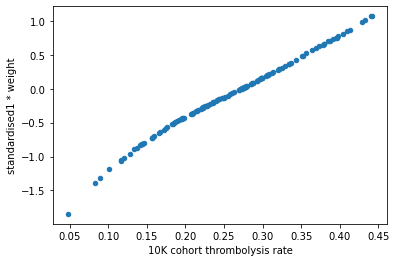

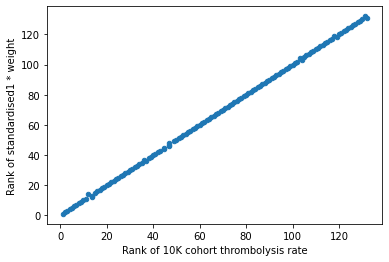

In [13]:
df_weights_thrombrate["standardised1 * weight"] = (
    df_weights_thrombrate["standardised1"] * df_weights_thrombrate["weight"])

df_weights_thrombrate.plot.scatter(
                        x='10K cohort thrombolysis rate', 
                        y='standardised1 * weight')

# calculate ranks
# note that ranks are in reverse order so that the points on the graph are
# more relatable to the position of the raw values
# high raw value = high ranking position
df_weights_thrombrate['Rank of standardised1 * weight'] = (
    df_weights_thrombrate['standardised1 * weight'].rank(
                                                    ascending=True).values)

# plot scatter of ranks (thrombolysis rate vs weight)
df_weights_thrombrate.plot.scatter(x='Rank of 10K cohort thrombolysis rate', 
                                   y='Rank of standardised1 * weight')

This shows that the hospitals keeness to thrombolyse can be summarised by the combination of the hosptial one hot feature weight and the standardised value. However there is still a little kink in the graph, we have not yet achieved a perfect 1:1 relationship.

Next also include the sum of the (standardised0 * weight) for the contributions coming from not going to all of the other hosptials?

### Plot the hospitals 10k patient thrombolysis rate vs the weighted hospital features

For each hospital plot the weighted hospital one-hot features (the summed dot product of standardised one-hot encoding and one-hot co-efficients).

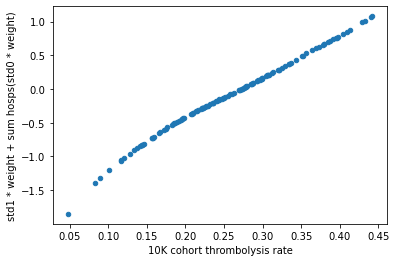

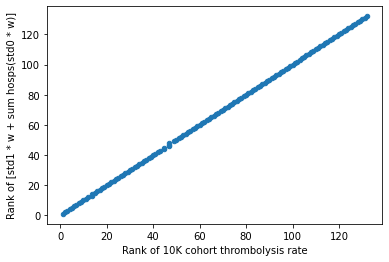

In [14]:
arr = np.array(())

#plot scatter of thrombolysis rate vs weight, colour points by admissions
for i in range(df_weights_thrombrate.shape[0]):
    factor = df_weights_thrombrate["standardised0"].copy(deep=True)
    factor[i] = df_weights_thrombrate.iloc[i]["standardised1"]
    sumproduct = np.dot(df_weights_thrombrate["weight"], factor)
    arr = np.append(arr, sumproduct)

y_label = "std1 * weight + sum hosps(std0 * weight)"
df_weights_thrombrate[y_label] = arr

df_weights_thrombrate.plot.scatter(x='10K cohort thrombolysis rate', 
                                   y=y_label)

# calculate ranks
# note that ranks are in reverse order so that the points on the graph are
# more relatable to the position of the raw values
# high raw value = high ranking position
y_label_rank = "Rank of [std1 * w + sum hosps(std0 * w)]"
df_weights_thrombrate[y_label_rank] = (
        df_weights_thrombrate[y_label].rank(ascending=True).values)

#plot scatter of ranks (thrombolysis rate vs weight)
df_weights_thrombrate.plot.scatter(x='Rank of 10K cohort thrombolysis rate',
                                   y=y_label_rank )

plt.show()

## Result

The hospitals keeness to thrombolyse can be summarised by the combination of the feature weight and the standardised value.

### Extra analysis 

### The graph "hospitals 10k patient thrombolysis rate vs the hospital feature co-efficient"

Let's revisit the earlier graphs showing the hospitals 10k patient thrombolysis rate vs the hospital feature co-efficient, now also show the admission rate from the training set.

### Plot the hospitals 10k patient thrombolysis rate vs the hospital feature co-efficient, colour to represent admissions

<AxesSubplot:xlabel='10K cohort thrombolysis rate', ylabel='weight'>

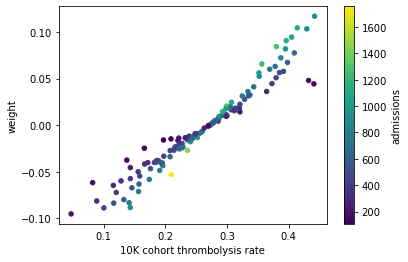

In [15]:
#plot scatter of thrombolysis rate vs weight, colour points by admissions
df_weights_thrombrate.plot.scatter(x='10K cohort thrombolysis rate', 
                                   y='weight', 
                                   c='admissions', 
                                   colormap='viridis', sharex=False)

Expected to see all blue on the underside of the 1:1 line, and yellow on the upper side of the 1:1 line.

Taking the two points on the right (with 10k thrombolysis rate of ~0.45 and a weight of ~0.5) as an example, these have a higher thrombolysis rate than we would expect by just assessing the weights. The 1:1 line suggests a weight of 0.5 gives a thrombolysis rate of ~0.35.

For these hospitals to have a higher thrombolysis rate than weights imply, means they have a relatively larger standardised value to represent "1" (which bumps the thrombolysis rate up). This is obtained by hospitals having fewer admissions.

The dark blue shows that these hosptials do have a low admission.

Let's identify these two hosptials that are these two outliers.

In [16]:
mask1 = df_weights_thrombrate['10K cohort thrombolysis rate'] > 0.42
mask2 = df_weights_thrombrate['weight'] > 0.04
mask3 = df_weights_thrombrate['weight'] < 0.05
mask = mask1 * mask2 * mask3
outlier_hosp = df_weights_thrombrate[mask]
df_hospital_admissions.loc[outlier_hosp.index]

,admissions,admissions_rank
CNBGF2713O,135,4.0
HPWIF9956L,178,8.0


In [17]:
df_weights_thrombrate.loc[outlier_hosp.index]

,weight,10K cohort thrombolysis rate,Rank of weight,Rank of 10K cohort thrombolysis rate,admissions,admissions_rank,standardised0,standardised1,standardised1 * weight,Rank of standardised1 * weight,std1 * weight + sum hosps(std0 * weight),Rank of [std1 * w + sum hosps(std0 * w)]
CNBGF2713O,0.044276,0.4410,112.0,131.0,135,4.0,-0.041428,24.138029,1.068733,132.0,1.069945,131.0
HPWIF9956L,0.047894,0.4324,114.0,130.0,178,8.0,-0.047584,21.015511,1.006517,130.0,1.008173,130.0


But this argument does not hold for the hosptial with the high admission (yellow) which is also to the RHS of the 1:1 line. Would expect a hospital with a high admission to have a lower std1 value, and so the thrombolysis rate to be lower than the weight alone would imply. But the thrombolysis rate is higher.

Let's extract that hospital's details.

In [18]:
mask1 = df_weights_thrombrate['10K cohort thrombolysis rate'] > 0.2
mask2 = df_weights_thrombrate['10K cohort thrombolysis rate'] < 0.22
mask3 = df_weights_thrombrate['weight'] < -0.05
mask4 = df_weights_thrombrate['weight'] > -0.06
mask = mask1 * mask2 * mask3 * mask4
outlier_hosp = df_weights_thrombrate[mask]
df_hospital_admissions.loc[outlier_hosp.index]

,admissions,admissions_rank
FAJKD7118X,1756,132.0


In [19]:
df_weights_thrombrate.loc[outlier_hosp.index]

,weight,10K cohort thrombolysis rate,Rank of weight,Rank of 10K cohort thrombolysis rate,admissions,admissions_rank,standardised0,standardised1,standardised1 * weight,Rank of standardised1 * weight,std1 * weight + sum hosps(std0 * weight),Rank of [std1 * w + sum hosps(std0 * w)]
FAJKD7118X,-0.053039,0.2096,18.0,39.0,1756,132.0,-0.150979,6.623455,-0.351302,39.0,-0.359932,39.0


The reason is because the weight is negative, and so now the effect is opposite.

For this hospital to have a higher thrombolysis rate than the weight implies, means it has a relatively smaller standardised value to represent "1" (which minimises the amount at which the thrombolysis is reduced, when the weight is negative). This is obtained by hospitals having larger admissions.

#### In summary:
##### Any point above the weight = 0 line:
Expect blue admissions to the RHS of the 1:1 line, and yellow admissions to the LHS of the 1:1 line.\
(why expect blue points on RHS of the 1:1 line: the weights are positive and so want a smaller admission hospital to have a larger standardised value to push the weight to a larger than expected thrombolysis rate).\
##### Any point below the weight = 0 line:
Expect yellow admissions to the RHS of the 1:1 line, and blue admissions to the LHS of the 1:1 line.\
(why expect yellow points on RHS of the 1:1 line: the weights are negative and so want a larger admission hospital to have a smaller standardised value to reduce the amount that the weight impedes the thrombolysis rate, and so end up with a larger than expected thrombolysis rate).

## The different order of the hosptial names
To get the set of unique hospital names depends on which object you call

train['StrokeTeam']: order of all the instances
np.unique(train['StrokeTeam']): alphabetical
set(train['StrokeTeam']): unordered, but shown alphabetical
list(set(train['StrokeTeam'])): random order, can change

When loop through all of the hospitals (to send each all the 10k patients in the test set to the same hosptial) it uses the order returned by list(set(train['StrokeTeam'])). By using the team name, the code finds the corresponding column in the dataframe column titles, and sets that column to all be 1 (the rest as zero).

One hot columns are returned in alphabetical order (and so do not reflect the hosptial order in the "StrokeTeam" column, or the list(set()) order).

When one hot the StrokeTeam column, the individual team columns are in alphabetical order. These are added to the model in that order.
Feature weights for the hospitals are in hospital alphabetical order.
Standardised data for the hospitals are in hospital alphabetical order.

## Observations

We discovered that when you standardise the dataset (the process of converting each feature independently to have a mean of 0 and standard deviation of 1), where one-hot features used to have a value of 0 and 1, they each now take a different pair of values. The resulting pair of values depends on how many instances have the value "1" for each hospital (effectively, the hospitals admission rate in the training set). The fewer patients the greater the standardised value for being one-hot. Therefore, with one-hot encoding the contribution of the ‘one hot’ feature depends on both the co-efficient and the standardised value for being one-hot. We cannot therefore take the logistic regression co-efficients in isoltaion and assume that they provide us with the relative importance.